# Analysis for Thesis: Passive Haptic Feedback and Cardiac Cycle Modulation in Virtual Reality Set-Up

In [731]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from ydata_profiling import ProfileReport
import statsmodels
#from statsmodels.stats.anova import AnovaRM
#import patsy
#from autoviz import AutoViz_Class 

In [732]:
import numpy as np
from scipy import stats
import pandas as pd
from pandas import DataFrame, Index
import patsy

from statsmodels.regression.linear_model import OLS
from statsmodels.compat.python import lrange
from statsmodels.formula.formulatools import (_remove_intercept_patsy,
                                    _has_intercept, _intercept_idx)
from statsmodels.iolib import summary2

def _not_slice(slices, slices_to_exclude, n):
    ind = np.array([True]*n)
    for term in slices_to_exclude:
        s = slices[term]
        ind[s] = False
    return ind

def _ssr_reduced_model(y, x, term_slices, params, keys):
    """
    Residual sum of squares of OLS model excluding factors in `keys`
    Assumes x matrix is orthogonal

    Parameters
    ----------
    y : array_like
        dependent variable
    x : array_like
        independent variables
    term_slices : a dict of slices
        term_slices[key] is a boolean array specifies the parameters
        associated with the factor `key`
    params : ndarray
        OLS solution of y = x * params
    keys : keys for term_slices
        factors to be excluded

    Returns
    -------
    rss : float
        residual sum of squares
    df : int
        degrees of freedom
    """
    ind = _not_slice(term_slices, keys, x.shape[1])
    params1 = params[ind]
    ssr = np.subtract(y, x[:, ind].dot(params1))
    ssr = ssr.T.dot(ssr)
    df_resid = len(y) - len(params1)
    return ssr, df_resid


def fit(self):
    """Estimate the model and compute the Anova table.

    Returns:
    AnovaResults instance.
    """
    y = self.data[self.depvar].values

    # Construct OLS endog and exog from string using patsy
    within = ['C(%s, Sum)' % i for i in self.within]
    subject = 'C(%s, Sum)' % self.subject
    factors = within + [subject]
    x = patsy.dmatrix('*'.join(factors), data=self.data)
    term_slices = x.design_info.term_name_slices
    for key in term_slices:
        ind = np.array([False]*x.shape[1])
        ind[term_slices[key]] = True
        term_slices[key] = np.array(ind)
    term_exclude = [':'.join(factors)]
    ind = _not_slice(term_slices, term_exclude, x.shape[1])
    x = x[:, ind]

    # Fit OLS
    model = OLS(y, x)
    results = model.fit()
    if model.rank < x.shape[1]:
        raise ValueError('Independent variables are collinear.')
    for i in term_exclude:
        term_slices.pop(i)
    for key in term_slices:
        term_slices[key] = term_slices[key][ind]
    params = results.params
    df_resid = results.df_resid
    ssr = results.ssr

    anova_table = pd.DataFrame(
        {'F Value': [], 'Num DF': [], 'Den DF': [], 'Pr > F': []})

    # Rest of your code here...

    # Return AnovaResults with the anova table
    return AnovaResults(anova_table)

class AnovaResults:
    """
    Anova results class

    Attributes
    ----------
    anova_table : DataFrame
    """
    def __init__(self, anova_table):
        self.anova_table = anova_table

    def __str__(self):
        return self.summary().__str__()

    def summary(self):
        """create summary results

        Returns
        -------
        summary : summary2.Summary instance
        """
        summ = summary2.Summary()
        summ.add_title('Anova')
        summ.add_df(self.anova_table)

        return summ

class MyCustomAnovaRM(AnovaRM):
    def fit(self):
        """estimate the model and compute the Anova table


        Returns
        -------
        AnovaResults instance


        """
        y = self.data[self.depvar].values


        # Construct OLS endog and exog from string using patsy
        within = ['C(%s, Sum)' % i for i in self.within]
        subject = 'C(%s, Sum)' % self.subject
        factors = within + [subject]
        x = patsy.dmatrix('*'.join(factors), data=self.data)
        term_slices = x.design_info.term_name_slices
        for key in term_slices:
            ind = np.array([False]*x.shape[1])
            ind[term_slices[key]] = True
            term_slices[key] = np.array(ind)
        term_exclude = [':'.join(factors)]
        ind = _not_slice(term_slices, term_exclude, x.shape[1])
        x = x[:, ind]


        # Fit OLS
        model = OLS(y, x)
        results = model.fit()
        if model.rank < x.shape[1]:
            raise ValueError('Independent variables are collinear.')
        for i in term_exclude:
            term_slices.pop(i)
        for key in term_slices:
            term_slices[key] = term_slices[key][ind]
        params = results.params
        df_resid = results.df_resid
        ssr = results.ssr


        anova_table = pd.DataFrame(
            {'F Value': [], 'Num DF': [], 'Den DF': [], 'Pr > F': []})


        for key in term_slices:
            print(key)
            if self.subject not in key and key != 'Intercept':
                #  Independent variables are orthogonal
                ssr1, df_resid1 = _ssr_reduced_model(
                    y, x, term_slices, params, [key])
                df1 = df_resid1 - df_resid
                msm = (ssr1 - ssr) / df1


                if (key == ':'.join(factors[:-1]) or
                        (key + ':' + subject not in term_slices)):
                    # Interaction effect ### Edit 04/10/2018
                    mse = ssr / df_resid
                    df2 = df_resid
                    type_3_SS_error = ssr ### Edit 04/10/2018


                else:
                    # Simple main effect
                    ssr1, df_resid1 = _ssr_reduced_model(
                        y, x, term_slices, params,
                        [key + ':' + subject])
                    df2 = df_resid1 - df_resid
                    mse = (ssr1 - ssr) / df2
                    type_3_SS_error = ssr1 - ssr ### Edit 04/10/2018


                F = msm / mse
                p = stats.f.sf(F, df1, df2)
                term = key.replace('C(', '').replace(', Sum)', '')
                anova_table.loc[term, 'F Value'] = F
                anova_table.loc[term, 'Num DF'] = df1
                anova_table.loc[term, 'Den DF'] = df2
                anova_table.loc[term, 'Pr > F'] = p
                # ---------------- Edit 04/10/2018 ----------------- #
                anova_table.loc[term, 'T3 SS'] = msm
                anova_table.loc[term, 'T3 SS (error)'] = type_3_SS_error


                # calculate effect sizes.
                ss_total = np.var(y, ddof=1) * (len(y) - 1)
                omega_squared = (msm - (df1 * mse)) / (ss_total + mse) # omega squared
                eta_squared = msm / ss_total
                partial_eta_squared = msm / (msm + type_3_SS_error)


                anova_table.loc[term, 'eta^2'] = eta_squared
                anova_table.loc[term, 'par.eta^2'] = partial_eta_squared
                anova_table.loc[term, 'omega^2'] = omega_squared
                # ---------------- Edit 04/10/2018 ---------------- #

        #result = super().fit()  # Call the original fit method if necessary

        #return AnovaResults(anova_table.iloc[:, [1, 2, 0, 3]])
        return AnovaResults(anova_table.iloc[:, [4, 5, 1, 2, 0, 3, 6, 7, 8]])




## 1. Loading Dataset

In [733]:
dataframe = pd.read_csv('database.csv', na_values=[''])
work_qstn =  pd.read_csv('meta-data.csv',na_values= [''])

## 2. Ordering Columns & Modifiying Variable Types

2.a First we need to select onls the varaibles I will use in the analysis. Set them up in an easier to read order.

In [734]:
dataframe.columns.tolist()

['Unnamed: 0',
 'row_close',
 'levelCounter',
 'trial_set',
 'time_close',
 'row_start',
 'time_start',
 'time',
 'time_ms',
 'ptcp',
 'feedbackType',
 'correctCounter',
 'Change Flag']

In [735]:
new_order = ['ptcp',
             'trial_set',
             'levelCounter',
             #'row_start',
             #'row_close',
             'time_ms',
             'feedbackType',
             'correctCounter'
             ]

2.b Here I take a look into the variable types and null values. As well as a list with all column names.

In [736]:
work_df = dataframe[new_order]
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ptcp            2362 non-null   object 
 1   trial_set       2362 non-null   int64  
 2   levelCounter    2358 non-null   float64
 3   time_ms         2325 non-null   float64
 4   feedbackType    2358 non-null   object 
 5   correctCounter  2193 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 110.8+ KB


In [737]:
work_qstn.columns.tolist()

['PARTICIPANT ID',
 'DATE OF T ESTING',
 'TIME',
 'HANDEDNESS',
 'SEX',
 'AGE',
 'COMMENTS',
 'pre',
 'post',
 'body°',
 'file numbers',
 'pre_csq1',
 'pre_csq2',
 'pre_csq3',
 'pre_csq4',
 'pre_csq5',
 'pre_csq6',
 'pre_csq7',
 'pre_csq8',
 'pre_csq9',
 'pre_csq10',
 'pre_csq11',
 'pre_csq12',
 'pre_csq13',
 'pre_csq14',
 'pre_csq15',
 'pre_csq16',
 'post_csq1',
 'post_csq2',
 'post_csq3',
 'post_csq4',
 'post_csq5',
 'post_csq6',
 'post_csq7',
 'post_csq8',
 'post_csq9',
 'post_csq10',
 'post_csq11',
 'post_csq12',
 'post_csq13',
 'post_csq14',
 'post_csq15',
 'post_csq16',
 'EHQ1',
 'EHQ2',
 'EHQ3',
 'EHQ4',
 'EHQ5',
 'EHQ6',
 'EHQ7',
 'EHQ8',
 'EHQ9',
 'EHQ10',
 'EHQI',
 'EHQII',
 'EHQ_F',
 'post_VRF1',
 'post_VRF2',
 'post_VRF3',
 'post_VRF4',
 'post_VRF5',
 'post_VRF6',
 'post_VRF7',
 'post_VRF8',
 'post_VRF9',
 'post_VRF10',
 'post_VRF11',
 'post_VRF12',
 'post_VRF13',
 'post_VRF14',
 'post_VRF15',
 'post_VRF16',
 'post_VRF17',
 'post_VRF18',
 'post_VRF19',
 'post_VRF20',
 'post

2.c Streamlining the Analysis by Removing Unnecessary Columns, selecting new order and columns to keep.

In [738]:
new_order = ['PARTICIPANT ID',
 #'DATE OF T ESTING',
 #'TIME',
 'HANDEDNESS',
 'SEX',
 'AGE',
 #'COMMENTS',
 'pre',
 'post',
 'body°',
 #'file numbers',
 'pre_csq1',
 'pre_csq2',
 'pre_csq3',
 'pre_csq4',
 'pre_csq5',
 'pre_csq6',
 'pre_csq7',
 'pre_csq8',
 'pre_csq9',
 'pre_csq10',
 'pre_csq11',
 'pre_csq12',
 'pre_csq13',
 'pre_csq14',
 'pre_csq15',
 'pre_csq16',
 'post_csq1',
 'post_csq2',
 'post_csq3',
 'post_csq4',
 'post_csq5',
 'post_csq6',
 'post_csq7',
 'post_csq8',
 'post_csq9',
 'post_csq10',
 'post_csq11',
 'post_csq12',
 'post_csq13',
 'post_csq14',
 'post_csq15',
 'post_csq16',
 'EHQ1',
 'EHQ2',
 'EHQ3',
 'EHQ4',
 'EHQ5',
 'EHQ6',
 'EHQ7',
 'EHQ8',
 'EHQ9',
 'EHQ10',
 'EHQI',
 'EHQII',
 'EHQ_F',
 'post_VRF1',
 'post_VRF2',
 'post_VRF3',
 'post_VRF4',
 'post_VRF5',
 'post_VRF6',
 'post_VRF7',
 'post_VRF8',
 'post_VRF9',
 'post_VRF10',
 'post_VRF11',
 'post_VRF12',
 'post_VRF13',
 'post_VRF14',
 'post_VRF15',
 'post_VRF16',
 'post_VRF17',
 'post_VRF18',
 'post_VRF19',
 'post_VRF20',
 'post_VRF21',
 'post_VRF22',
 'post_VRF23',
 'post_VRF24',
 'post_VRF25',
 'post_VRF26',
 'post_VRF27']

In [739]:
work_qstn = work_qstn[new_order]

2.d Strings modification to allow for the merging of questionaire and behavioral data into one dataFrame. All this modifications over the questionaire df and merged. 

In [740]:
work_qstn['ptcp'] = work_qstn['PARTICIPANT ID'].str.lower().str.replace('_', '', regex=True)
work_qstn['ptcp'] = work_qstn['ptcp'].str.replace('_', '', regex=True)
work_qstn['ptcp'] = work_qstn['ptcp'].str.replace('-backup', '', regex=True)
work_qstn['body°'] = work_qstn['body°'].str.replace('°', '', regex=True).astype('float64')
# List of columns that need to be converted
columns_to_convert = [
    'post_VRF1', 'post_VRF2', 'post_VRF3', 'post_VRF4', 'post_VRF5', 'post_VRF6',
    'post_VRF7', 'post_VRF8', 'post_VRF9', 'post_VRF10', 'post_VRF11', 'post_VRF12',
    'post_VRF13', 'post_VRF14', 'post_VRF15', 'post_VRF16', 'post_VRF17', 'post_VRF18',
    'post_VRF19', 'post_VRF20', 'post_VRF21', 'post_VRF22', 'post_VRF23', 'post_VRF24',
    'post_VRF25', 'post_VRF26']

for column in columns_to_convert:
    # Replace space characters with NaN
    work_qstn[column] = work_qstn[column].replace(' ', np.nan)


work_qstn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PARTICIPANT ID  23 non-null     object 
 1   HANDEDNESS      23 non-null     object 
 2   SEX             23 non-null     object 
 3   AGE             23 non-null     int64  
 4   pre             23 non-null     int64  
 5   post            21 non-null     object 
 6   body°           23 non-null     float64
 7   pre_csq1        22 non-null     float64
 8   pre_csq2        23 non-null     int64  
 9   pre_csq3        22 non-null     float64
 10  pre_csq4        23 non-null     int64  
 11  pre_csq5        23 non-null     int64  
 12  pre_csq6        23 non-null     int64  
 13  pre_csq7        23 non-null     int64  
 14  pre_csq8        23 non-null     int64  
 15  pre_csq9        23 non-null     int64  
 16  pre_csq10       23 non-null     int64  
 17  pre_csq11       23 non-null     int64

In [741]:
merged_df = pd.merge(work_df, work_qstn, on='ptcp', how='left')

2.e I will transfor 'ptcp' and 'trial set' in categorical values because the represent the participants, the stage at which the experiment developed and the feedback category. Not really numerical values but levels. Also, except for metadata, I treated all Likert Scale questionaires as Numerical (Bug Debate over this -  include reference ???) 

In [742]:
#------ Behavioral data treatment
merged_df.loc[:, 'ptcp'] = merged_df['ptcp'].astype('category')
merged_df.loc[:, 'trial_set'] = merged_df['trial_set'].astype('category')
merged_df.loc[:, 'feedbackType'] = merged_df['feedbackType'].astype('category')
#------ Metadata treatment
merged_df.loc[:, 'HANDEDNESS'] = merged_df['HANDEDNESS'].astype('category')
merged_df.loc[:, 'SEX'] = merged_df['SEX'].astype('category')
merged_df.loc[:, 'AGE'] = merged_df['AGE'].astype('int')
merged_df.loc[:, 'pre'] = merged_df['pre'].astype('int')
merged_df.loc[:, 'post'] = merged_df['post'].astype('Int64')
#------ Pre Cyber Sickness Questionaire 
merged_df.loc[:, 'pre_csq1'] = merged_df['pre_csq1'].astype('Int64')
merged_df.loc[:, 'pre_csq2'] = merged_df['pre_csq2'].astype('Int64')
merged_df.loc[:, 'pre_csq3'] = merged_df['pre_csq3'].astype('Int64')
merged_df.loc[:, 'pre_csq4'] = merged_df['pre_csq4'].astype('Int64')
merged_df.loc[:, 'pre_csq5'] = merged_df['pre_csq5'].astype('Int64')
merged_df.loc[:, 'pre_csq6'] = merged_df['pre_csq6'].astype('Int64')
merged_df.loc[:, 'pre_csq7'] = merged_df['pre_csq7'].astype('Int64')
merged_df.loc[:, 'pre_csq8'] = merged_df['pre_csq8'].astype('Int64')
merged_df.loc[:, 'pre_csq9'] = merged_df['pre_csq9'].astype('Int64')
merged_df.loc[:, 'pre_csq10'] = merged_df['pre_csq10'].astype('Int64')
merged_df.loc[:, 'pre_csq11'] = merged_df['pre_csq11'].astype('Int64')
merged_df.loc[:, 'pre_csq12'] = merged_df['pre_csq12'].astype('Int64')
merged_df.loc[:, 'pre_csq13'] = merged_df['pre_csq13'].astype('Int64')
merged_df.loc[:, 'pre_csq14'] = merged_df['pre_csq14'].astype('Int64')
merged_df.loc[:, 'pre_csq15'] = merged_df['pre_csq15'].astype('Int64')
merged_df.loc[:, 'pre_csq16'] = merged_df['pre_csq16'].astype('Int64')
#------ Post Cyber Sickness Questionaire 
merged_df.loc[:, 'post_csq1'] = merged_df['post_csq1'].astype('Int64')
merged_df.loc[:, 'post_csq2'] = merged_df['post_csq2'].astype('Int64')
merged_df.loc[:, 'post_csq3'] = merged_df['post_csq3'].astype('Int64')
merged_df.loc[:, 'post_csq4'] = merged_df['post_csq4'].astype('Int64')
merged_df.loc[:, 'post_csq5'] = merged_df['post_csq5'].astype('Int64')
merged_df.loc[:, 'post_csq6'] = merged_df['post_csq6'].astype('Int64')
merged_df.loc[:, 'post_csq7'] = merged_df['post_csq7'].astype('Int64')
merged_df.loc[:, 'post_csq8'] = merged_df['post_csq8'].astype('Int64')
merged_df.loc[:, 'post_csq9'] = merged_df['post_csq9'].astype('Int64')
merged_df.loc[:, 'post_csq10'] = merged_df['post_csq10'].astype('Int64')
merged_df.loc[:, 'post_csq11'] = merged_df['post_csq11'].astype('Int64')
merged_df.loc[:, 'post_csq12'] = merged_df['post_csq12'].astype('Int64')
merged_df.loc[:, 'post_csq13'] = merged_df['post_csq13'].astype('Int64')
merged_df.loc[:, 'post_csq14'] = merged_df['post_csq14'].astype('Int64')
merged_df.loc[:, 'post_csq15'] = merged_df['post_csq15'].astype('Int64')
merged_df.loc[:, 'post_csq16'] = merged_df['post_csq16'].astype('Int64')
#------ Handedness Questionaire.
merged_df.loc[:, 'EHQ1'] =  merged_df['EHQ1'].astype('Int64')
merged_df.loc[:, 'EHQ2'] =  merged_df['EHQ2'].astype('Int64')
merged_df.loc[:, 'EHQ3'] =  merged_df['EHQ3'].astype('Int64')
merged_df.loc[:, 'EHQ4'] =  merged_df['EHQ4'].astype('Int64')
merged_df.loc[:, 'EHQ5'] =  merged_df['EHQ5'].astype('Int64')
merged_df.loc[:, 'EHQ6'] =  merged_df['EHQ6'].astype('Int64')
merged_df.loc[:, 'EHQ7'] =  merged_df['EHQ7'].astype('Int64')
merged_df.loc[:, 'EHQ8'] =  merged_df['EHQ8'].astype('Int64')
merged_df.loc[:, 'EHQ9'] =  merged_df['EHQ9'].astype('Int64')
merged_df.loc[:, 'EHQ10'] =  merged_df['EHQ10'].astype('Int64')
merged_df.loc[:, 'EHQI'] =  merged_df['EHQI'].astype('Int64')
merged_df.loc[:, 'EHQII'] =  merged_df['EHQII'].astype('Int64')
merged_df.loc[:, 'EHQ1_F'] =  merged_df['EHQ_F'].astype('category')
#------ 
merged_df.loc[:, 'post_VRF1'] =  merged_df['post_VRF1'].astype('Int64')
merged_df.loc[:, 'post_VRF3'] =  merged_df['post_VRF3'].astype('Int64')
merged_df.loc[:, 'post_VRF4'] =  merged_df['post_VRF4'].astype('Int64')
merged_df.loc[:, 'post_VRF5'] =  merged_df['post_VRF5'].astype('Int64')
merged_df.loc[:, 'post_VRF6'] =  merged_df['post_VRF6'].astype('Int64')
merged_df.loc[:, 'post_VRF7'] =  merged_df['post_VRF7'].astype('Int64')
merged_df.loc[:, 'post_VRF8'] =  merged_df['post_VRF8'].astype('Int64')
merged_df.loc[:, 'post_VRF9'] =  merged_df['post_VRF9'].astype('Int64')
merged_df.loc[:, 'post_VRF10'] =  merged_df['post_VRF10'].astype('Int64')
merged_df.loc[:, 'post_VRF11'] =  merged_df['post_VRF11'].astype('Int64')
merged_df.loc[:, 'post_VRF12'] =  merged_df['post_VRF12'].astype('Int64')
merged_df.loc[:, 'post_VRF13'] =  merged_df['post_VRF13'].astype('Int64')
merged_df.loc[:, 'post_VRF14'] =  merged_df['post_VRF14'].astype('Int64')
merged_df.loc[:, 'post_VRF15'] =  merged_df['post_VRF15'].astype('Int64')
merged_df.loc[:, 'post_VRF16'] =  merged_df['post_VRF16'].astype('Int64')
merged_df.loc[:, 'post_VRF17'] =  merged_df['post_VRF17'].astype('Int64')
merged_df.loc[:, 'post_VRF18'] =  merged_df['post_VRF18'].astype('Int64')
merged_df.loc[:, 'post_VRF19'] =  merged_df['post_VRF19'].astype('Int64')
merged_df.loc[:, 'post_VRF20'] =  merged_df['post_VRF20'].astype('Int64')
merged_df.loc[:, 'post_VRF21'] =  merged_df['post_VRF21'].astype('Int64')
merged_df.loc[:, 'post_VRF22'] =  merged_df['post_VRF22'].astype('Int64')
merged_df.loc[:, 'post_VRF23'] =  merged_df['post_VRF23'].astype('Int64')
merged_df.loc[:, 'post_VRF24'] =  merged_df['post_VRF24'].astype('Int64')
merged_df.loc[:, 'post_VRF25'] =  merged_df['post_VRF25'].astype('Int64')
merged_df.loc[:, 'post_VRF26'] =  merged_df['post_VRF26'].astype('Int64')





## 3. Data Validation & Data Cleaning

### **Here I check that some mininum conditions expected for the data set hold. And make corrections in case they don't.** 

3.a When we designed the experiment we expected 22 participants and 36 trials per set. 

In [743]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
levels_per_set_per_participant = merged_df.groupby(['ptcp', 'trial_set'], observed=True)['levelCounter'].count()

# Display the result
print("\nNumber of levels per set per participant:")
print(levels_per_set_per_participant)


Number of levels per set per participant:
ptcp    trial_set
tsvr06  1            36
        2            36
        3            36
tsvr07  1            36
        2            36
                     ..
tsvr26  2            36
        3            35
tsvr27  1            36
        2            36
        3            35
Name: levelCounter, Length: 66, dtype: int64


3.b The last level (35) is missing for most participants in set 3 due to bug in the excecution of the program while taking the experiment. I think we need to remove it for all participants in all sets since we don' want to umbalanced the results for some participants and for others not. As the the feedback was assigned randomly this should not affect the overall results. 

In [744]:
# removing 
work_df2 =  merged_df[merged_df['levelCounter']<35]
work_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2360
Data columns (total 86 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ptcp            2310 non-null   object  
 1   trial_set       2310 non-null   category
 2   levelCounter    2310 non-null   float64 
 3   time_ms         2310 non-null   float64 
 4   feedbackType    2310 non-null   object  
 5   correctCounter  2145 non-null   float64 
 6   PARTICIPANT ID  2310 non-null   object  
 7   HANDEDNESS      2310 non-null   object  
 8   SEX             2310 non-null   object  
 9   AGE             2310 non-null   int64   
 10  pre             2310 non-null   int64   
 11  post            2100 non-null   object  
 12  body°           2310 non-null   float64 
 13  pre_csq1        2205 non-null   Int64   
 14  pre_csq2        2310 non-null   int64   
 15  pre_csq3        2205 non-null   Int64   
 16  pre_csq4        2310 non-null   int64   
 17  pre_csq5        231

3.c After the removal of level 35,we have a number of levels not exactly as designed. Nonethelees this should not be a problem since the numbers are large enouth so that it is possible to maintain three independent and equally significant conditions.  To check that even if the number of trials per condition is not exactly the same, **I will check if the number of conditions debiates statistically from 0 from 36 levels for each participant and that each category has 22 participants.** 

In [745]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_level = work_df2.groupby(['levelCounter','feedbackType']).count()
check_per_level = check_per_level.reset_index()
check_per_level['deviation']= 22-check_per_level['ptcp']
print(check_per_level)



     levelCounter feedbackType  ptcp  trial_set  time_ms  correctCounter  \
0             0.0    congruent    21         21       21              21   
1             0.0  incongruent    22         22       22              16   
2             0.0         none    23         23       23              22   
3             1.0    congruent    23         23       23              20   
4             1.0  incongruent    23         23       23              22   
..            ...          ...   ...        ...      ...             ...   
100          33.0  incongruent    21         21       21              18   
101          33.0         none    25         25       25              23   
102          34.0    congruent    26         26       26              22   
103          34.0  incongruent    19         19       19              16   
104          34.0         none    21         21       21              21   

     PARTICIPANT ID  HANDEDNESS  SEX  AGE  ...  post_VRF20  post_VRF21  \
0            

3.c.1 The feedback Types are not exactly splited into three equal groups, there is a deviation wich I will look into at a participant level.  Next, we will t-test if this deviation is isgnificanttly different from 0. 
For every level we expect to see 22 participants in each condition, this is our ideal scenario. So for example, for level 1 we expect to have 22 partipants in case "congruent", 22 in case "incongruent" and 22 in case "none". Since this is not the case I will see how much the diviate form the ideal case (22 - x) and if this is statiscally different from 0. 

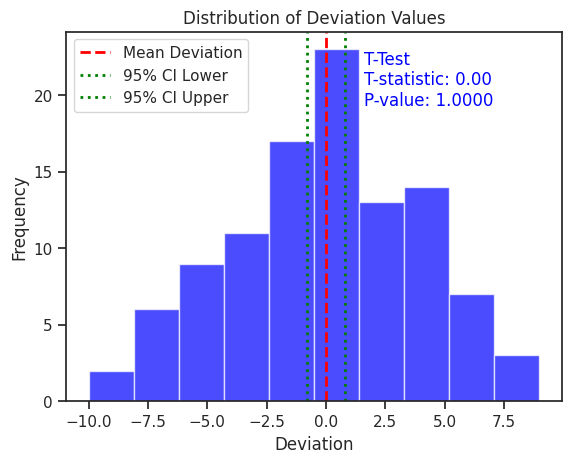

In [746]:

# Assuming your DataFrame is named check_per_level
deviation_values = check_per_level['deviation']

# Create the histogram
plt.hist(deviation_values, bins=10, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()


3.c.2 This shows that the median deviation of ptcp per category is 0. Which supports the argument that after removing level 35, when considering the sample overall, feedbacktype remains a legitimate independent variable. 

3.c.3 Now at a participantt point of view. We expect for each participantto have 36 levels pero condition. This is not now exactly the case so we creat a deviation varaible (36- x). The results look osmething like the following:

In [747]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_ptcp = work_df2.groupby(['ptcp','feedbackType']).count()
check_per_ptcp = check_per_ptcp.reset_index()
check_per_ptcp['deviation']= 35-check_per_ptcp['trial_set']
print(check_per_ptcp)

      ptcp feedbackType  trial_set  levelCounter  time_ms  correctCounter  \
0   tsvr06    congruent         35            35       35              33   
1   tsvr06  incongruent         34            34       34              31   
2   tsvr06         none         36            36       36              35   
3   tsvr07    congruent         35            35       35              32   
4   tsvr07  incongruent         33            33       33              30   
..     ...          ...        ...           ...      ...             ...   
61  tsvr26  incongruent         35            35       35              32   
62  tsvr26         none         35            35       35              33   
63  tsvr27    congruent         35            35       35              35   
64  tsvr27  incongruent         34            34       34              33   
65  tsvr27         none         36            36       36              36   

    PARTICIPANT ID  HANDEDNESS  SEX  AGE  ...  post_VRF20  post_VRF21  \
0 

3.c.4 I proceed to run a t.test to see if deviation is something different from 0. Its not .

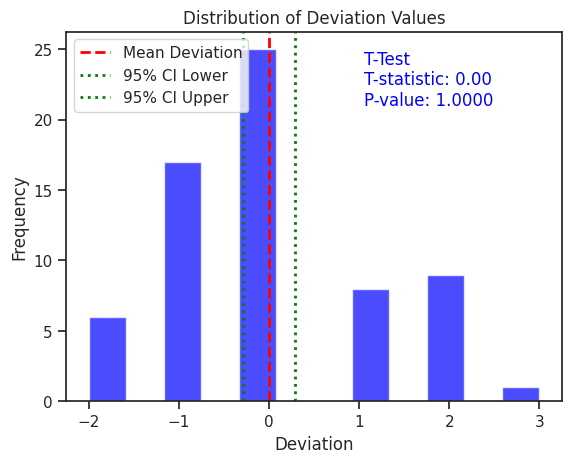

In [748]:
# Assuming your DataFrame is named check_per_level
deviation_values = check_per_ptcp['deviation']

# Create the histogram
plt.hist(deviation_values, bins=12, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()

3.d Here I run a program that summurizes all EDA for the Dataframe. I beleive this saves some time to run it like this. Although not all of it correct to use. **Please take a look at the y_dataprofiling.html file** 

In [749]:
profile = ProfileReport(work_df2, title='Yoyoma')
#profile.to_file("ydata_profiling.html")

3.d.1 As the EDA shows, reponse time is a highly skew variable with outlier. Wich we will remove and later tranform using natural log. Also I need to decide where in seconds I am going to make a cutoff. 

## 4. Feature Engineering 

### Step 1: Flagging Mistakes
In this step, we create a binary flag to distinguish between correct answers and mistakes in the dataset. We achieve this by utilizing the 'correct value count' variable. When analyzing the data, this flag will be invaluable for easily identifying the impact of incorrect responses. Specifically, we assign the value '1' to the flag when a mistake occurs, and '0' when the response is correct.

In [750]:
# Create a new column 'mistake_flag' based on 'correctCounter'
work_df2['mistake_flag'] = work_df2['correctCounter'].apply(lambda x: 1 if pd.isna(x) else 0)

# Convert 'mistake_flag' to 'int64' data type
work_df2.loc[:, 'mistake_flag'] = work_df2['mistake_flag'].astype('int64')

# Verify the column data types
work_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2360
Data columns (total 87 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ptcp            2310 non-null   object  
 1   trial_set       2310 non-null   category
 2   levelCounter    2310 non-null   float64 
 3   time_ms         2310 non-null   float64 
 4   feedbackType    2310 non-null   object  
 5   correctCounter  2145 non-null   float64 
 6   PARTICIPANT ID  2310 non-null   object  
 7   HANDEDNESS      2310 non-null   object  
 8   SEX             2310 non-null   object  
 9   AGE             2310 non-null   int64   
 10  pre             2310 non-null   int64   
 11  post            2100 non-null   object  
 12  body°           2310 non-null   float64 
 13  pre_csq1        2205 non-null   Int64   
 14  pre_csq2        2310 non-null   int64   
 15  pre_csq3        2205 non-null   Int64   
 16  pre_csq4        2310 non-null   int64   
 17  pre_csq5        231

/tmp/ipykernel_4828/3995844113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_df2['mistake_flag'] = work_df2['correctCounter'].apply(lambda x: 1 if pd.isna(x) else 0)


### Step 2: Exploring Feedbacktype and Response Time Relationships and removal

Now, let's explore the relationships and interactions between the 'feedbacktype' categories and response times:

/home/perdices/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


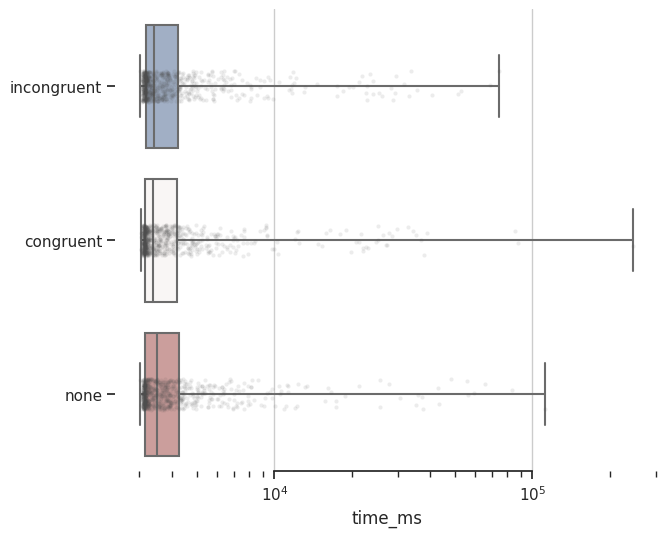

In [751]:
# Set the style of the graph
sns.set_theme(style='ticks')

# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plotting boxplot
sns.boxplot(
    data=work_df2, x='time_ms', y='feedbackType', 
    palette="vlag", whis=[0, 100],  showfliers=False
)

# Add points to show each observation
sns.stripplot(
    data=work_df, x='time_ms', y='feedbackType', size=3, color=".3",alpha=0.1, dodge=True
)


# Set the x-axis limits to 2500 and 10000 ms
#ax.set_xlim(2500, 10000)

# Show the plot
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
#plt.show()



#### Huge spread in response time and a hight Kurtosis 

At first sight there are no big differences overall in reponse time. When looking with attention Incongruent and Congruent are more similar. And "None" is slightly a more slower response time. 



#### Removing fail participants and trials with RT over first Q3.

Excluding Participant 27 due to incomplete participation and Participant 30 for exceeding the specified age limit.

In [752]:
# Removing participant 27 because of an incomplete participation and participant 30 because of being over the age limit. 
work_df_no_outl = work_df2[~work_df2['ptcp'].isin(['tsvr27', 'tsvr26'])]

Next we are going to cut in 4226 ms as is the upper limit for Quartile 3 of RT.  We do the boxplot again to see how does the data look now. 

IM GOING TO REDO THIS USING :
Comparison of Different Response Time Outlier Exclusion Methods: A Simulation Study

#### RT Transformation and Outlier Removal

In [753]:
# Creating a flag for each trial using the previous definition.
work_df_no_outl['rt_flag'] = work_df_no_outl['time_ms'].apply(lambda x: 'fast' if x <= 3400 else 'slow')
# Creating a log RT
work_df_no_outl['rt_log'] = work_df_no_outl['time_ms'].apply(lambda x: math.log(x, 10))


/tmp/ipykernel_4828/1360343678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_df_no_outl['rt_flag'] = work_df_no_outl['time_ms'].apply(lambda x: 'fast' if x <= 3400 else 'slow')
/tmp/ipykernel_4828/1360343678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_df_no_outl['rt_log'] = work_df_no_outl['time_ms'].apply(lambda x: math.log(x, 10))


In [754]:
# Code for removing all trial over 4226 milliseconds because its the Quartile border
#work_df_no_outl = work_df_no_outl[work_df_no_outl['time_ms'] <= 4226]
#work_df_no_outl.info()


#import pandas as pd

# Assuming you have a DataFrame 'work_df'

# Calculate the mean and standard deviation of 'time_ms'
mean = work_df_no_outl['time_ms'].mean()
std = work_df_no_outl['time_ms'].std()

# Define a threshold for outliers (e.g., 3 times the standard deviation)
threshold = 2 * std

# Create a new DataFrame with outliers removed
work_df_no_outl = work_df_no_outl[(work_df_no_outl['time_ms'] >= mean - threshold) & (work_df_no_outl['time_ms'] <= mean + threshold)]

# Display the information about the new DataFrame
work_df_no_outl.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2045 entries, 215 to 2360
Data columns (total 89 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ptcp            2045 non-null   object  
 1   trial_set       2045 non-null   category
 2   levelCounter    2045 non-null   float64 
 3   time_ms         2045 non-null   float64 
 4   feedbackType    2045 non-null   object  
 5   correctCounter  1898 non-null   float64 
 6   PARTICIPANT ID  2045 non-null   object  
 7   HANDEDNESS      2045 non-null   object  
 8   SEX             2045 non-null   object  
 9   AGE             2045 non-null   int64   
 10  pre             2045 non-null   int64   
 11  post            1839 non-null   object  
 12  body°           2045 non-null   float64 
 13  pre_csq1        1942 non-null   Int64   
 14  pre_csq2        2045 non-null   int64   
 15  pre_csq3        1949 non-null   Int64   
 16  pre_csq4        2045 non-null   int64   
 17  pre_csq5        2

with the Turkey1.5 method we have 1647 RT. 
WIth the 3sd we have 2070 different RT

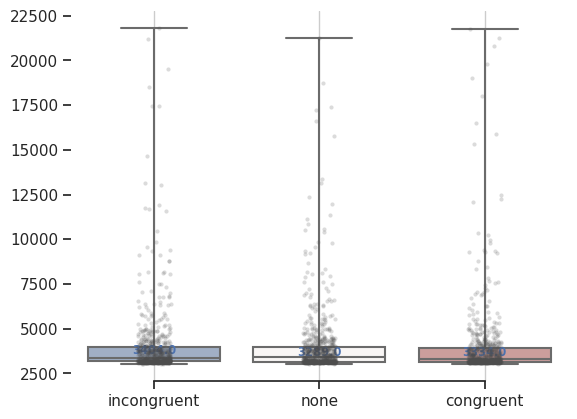

In [755]:


# Set the style of the graph
sns.set_theme(style='ticks')

# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots()
#ax.set_yscale("log")

# Plotting boxplot
box_plot = sns.boxplot(
    data=work_df_no_outl, y='time_ms', x='feedbackType', 
    palette="vlag", whis=[0, 100],  showfliers=False
)


medians = work_df_no_outl.groupby(['feedbackType'])['time_ms'].median()
medians = medians.reindex(index = ['none','congruent','incongruent'])
vertical_offset = work_df_no_outl['time_ms'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')




# Add points to show each observation
sns.stripplot(
    data=work_df_no_outl, y='time_ms', x='feedbackType', size=3, color=".3",alpha=0.2, dodge=True
)


# Set the x-axis limits to 2500 and 10000 ms
#ax.set_xlim(2500, 10000)

# Show the plot
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

#### PTCP: Analysis of Reaction Times for Each Participant's Condition

Now we consider each trial individually and we can see de difference between conditions, somewhat more clearly. With median value difference of 10 ms between congruent and incongruent and a difference of 30ms and 20ms between None-congruent and none-incongruent.

If we consider the difference for each Participant:

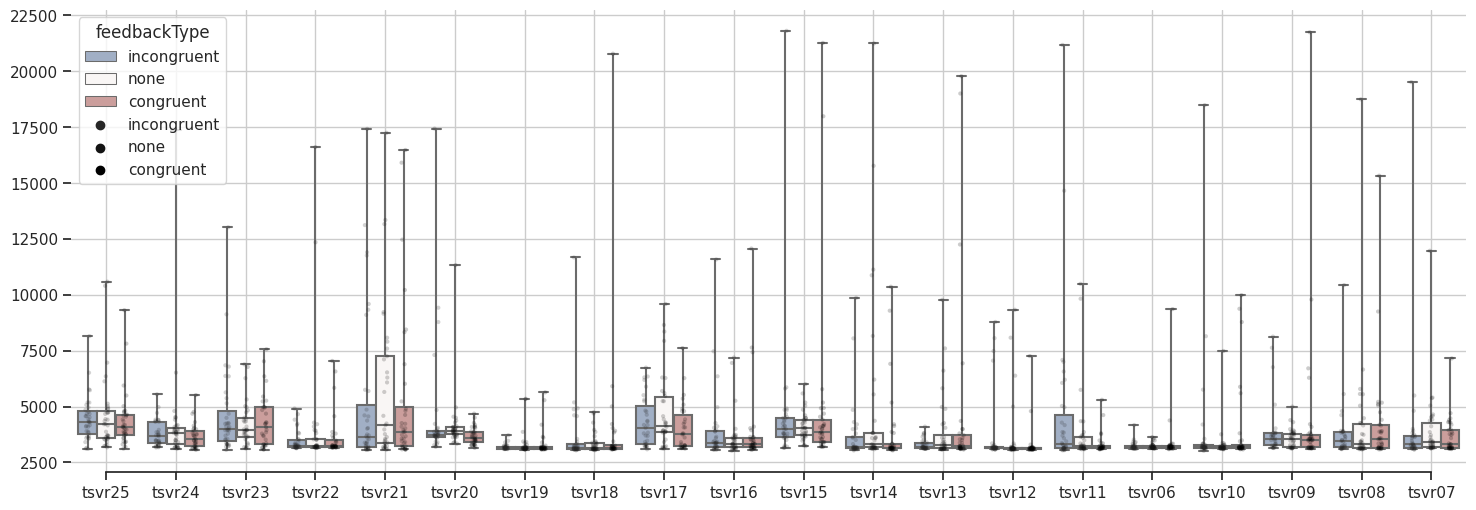

In [756]:

sns.set_theme(style='ticks')

# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots(figsize=(18,6))
#ax.set_yscale("log")

# Plotting boxplot
box_plot = sns.boxplot(
    data=work_df_no_outl, y='time_ms', x='ptcp', hue='feedbackType',
    palette="vlag", whis=[0, 100],  showfliers=False
)

'''
medians = work_df_no_outl.groupby(['feedbackType'])['time_ms'].median()
medians = medians.reindex(index = ['none','congruent','incongruent'])
vertical_offset = work_df_no_outl['time_ms'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

'''


# Add points to show each observation
sns.stripplot(
    data=work_df_no_outl, y='time_ms', x='ptcp', hue='feedbackType', size=3, palette='dark:black',alpha=0.2, dodge=True
)


# Set the x-axis limits to 2500 and 10000 ms
#ax.set_xlim(2500, 10000)

#ax.get_legend().remove()

# Show the plot
ax.grid()
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

Here we see the RT (ms) for each participant devided by conditions. First thing that pops into the eye is how different is for each individual. There is no clear patern. Also participant 27 is incomplete and needs to be remove. As well as the participant with 50 years. 

In [757]:
# Calculate the median RT for each condition
median_rt = work_df_no_outl.groupby(['ptcp', 'feedbackType'])['time_ms'].median().unstack()
median_rt['overall'] = work_df_no_outl.groupby('ptcp')['time_ms'].median()
# Check for the pattern
pattern_pairs = []
pattern_pairs_f = []
pattern_pairs_s = []
pattern_pairs_t = []
pattern_pairs_fo = []
pattern_pairs_fi= []
pattern_count = 0
f_pattern_count = 0
s_pattern_count = 0 
t_pattern_count = 0 
fo_pattern_count = 0 
fi_pattern_count = 0 

for participant in median_rt.index:
    if (median_rt.loc[participant, 'congruent'] < median_rt.loc[participant, 'incongruent']
            < median_rt.loc[participant, 'none']):
        pattern_count += 1
        pair = '( '+participant +' '+str(median_rt.loc[participant, 'overall'])+' )'
        pattern_pairs.append(pair)
    elif (median_rt.loc[participant, 'incongruent'] < median_rt.loc[participant, 'congruent']
            < median_rt.loc[participant, 'none']):
        f_pattern_count += 1
        pair = '( '+participant +' '+str(median_rt.loc[participant, 'overall'])+' )'
        pattern_pairs_f.append(pair)
    elif (median_rt.loc[participant, 'none'] < median_rt.loc[participant, 'congruent']
            < median_rt.loc[participant, 'incongruent']):
        s_pattern_count += 1
        pair = '( '+participant +' '+str(median_rt.loc[participant, 'overall'])+' )'
        pattern_pairs_s.append(pair)
    elif (median_rt.loc[participant, 'congruent'] < median_rt.loc[participant, 'none']
            < median_rt.loc[participant, 'incongruent']):
        t_pattern_count += 1
        pair = '( '+participant +' '+str(median_rt.loc[participant, 'overall'])+' )'
        pattern_pairs_t.append(pair)
    elif (median_rt.loc[participant, 'incongruent'] < median_rt.loc[participant, 'none']
            < median_rt.loc[participant, 'congruent']):
        fo_pattern_count += 1
        pair = '( '+participant +' '+str(median_rt.loc[participant, 'overall'])+' )'
        pattern_pairs_fo.append(pair)
    elif (median_rt.loc[participant, 'none'] < median_rt.loc[participant, 'incongruent']
            < median_rt.loc[participant, 'congruent']):
        fi_pattern_count += 1
        pair = '( '+participant +' '+str(median_rt.loc[participant, 'overall'])+' )'
        pattern_pairs_fi.append(pair)

# Display the count of participants with the pattern
print(f"Participants with 'congruent median' < 'incongruent median' < 'none median': {pattern_count} for participants: {', '.join(pattern_pairs)}")
print(f"Participants with 'incongruent median' < 'congruent median' < 'none median': {f_pattern_count} for participants: {', '.join(pattern_pairs_f)}")
print(f"Participants with 'none median' < 'congruent median' < 'incongruent median': {s_pattern_count} for participants: {', '.join(pattern_pairs_s)}")
print(f"Participants with 'congruent median' < 'none median' < 'incongruent median': {t_pattern_count} for participants: {', '.join(pattern_pairs_t)}")
print(f"Participants with 'incongruent median' < 'none median' < 'congruent median': {fo_pattern_count} for participants: {', '.join(pattern_pairs_fo)}")
print(f"Participants with 'none median' < 'incongruent median' < 'congruent median': {fi_pattern_count} for participants: {', '.join(pattern_pairs_fi)}")

Participants with 'congruent median' < 'incongruent median' < 'none median': 6 for participants: ( tsvr09 3530.5 ), ( tsvr14 3180.0 ), ( tsvr15 3989.0 ), ( tsvr17 3931.5 ), ( tsvr20 3768.0 ), ( tsvr24 3690.0 )
Participants with 'incongruent median' < 'congruent median' < 'none median': 3 for participants: ( tsvr07 3318.0 ), ( tsvr13 3213.0 ), ( tsvr21 3765.0 )
Participants with 'none median' < 'congruent median' < 'incongruent median': 3 for participants: ( tsvr10 3178.0 ), ( tsvr12 3137.5 ), ( tsvr19 3142.0 )
Participants with 'congruent median' < 'none median' < 'incongruent median': 3 for participants: ( tsvr11 3209.0 ), ( tsvr16 3355.0 ), ( tsvr25 4178.0 )
Participants with 'incongruent median' < 'none median' < 'congruent median': 1 for participants: ( tsvr18 3142.0 )
Participants with 'none median' < 'incongruent median' < 'congruent median': 3 for participants: ( tsvr06 3182.5 ), ( tsvr08 3408.0 ), ( tsvr23 3958.5 )


Having a closer look we see that for 11 participants (50%) the congruent conditions was the fastest reaction time. On this group is the mode of participants, in which 6 participants (27%) had the congruent condition as the fastes and the incongruent condition as the slowestm no Haptic feedback was in the middle as we guessed. 

A second group had the 'none' condition as the fastest 3 ptcp (13%) + 3 ptcp (13%) 

Incongruent condition was the fastest only for 5 participants (22%)

### Step 3: Time Bins

I as in our reference paper will take time bins. Wether to take the same time bins as in reference paper is not possible. Since the ask is a perception task, the time range runs between 0 and 1 seconds. In our VR-memory task individuals respond on a different time range. There for we consider from 3000 ms onward taking 20 bins of 100ms. untill the cutoff value of 4226 mls.

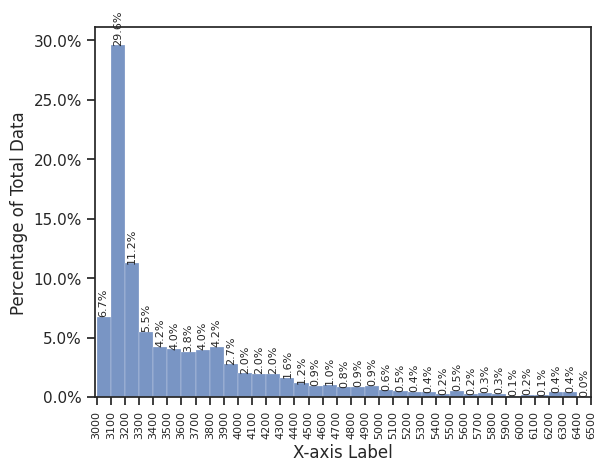

In [758]:


# Define the bin edges
bin_edges = range(3000, int(work_df_no_outl['time_ms'].max()) + 100, 100)

# Create the histogram with custom bin edges
ax = sns.histplot(data=work_df_no_outl, x='time_ms', bins=bin_edges, stat='percent')

# Customize the number of x-tick labels
plt.xticks(np.arange(3000, work_df_no_outl['time_ms'].max() + 100, 100), fontsize=8, rotation=90)

# Format y-axis labels as percentages with one decimal place
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Add labels to the x and y axes
plt.xlabel('X-axis Label')
plt.ylabel('Percentage of Total Data')
# Cut axis
plt.xlim(3000-10,6500)

# Add text with the percentage on top of each bar
for bar in ax.patches:
    percentage = bar.get_height()
    ax.annotate(f'{percentage:.1f}%', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom', fontsize=8, rotation=90)

# Show the plot
plt.show()




Lets take a look as to how does the response time label looks for each haptic condition:

What we see here is that for the "fast" responses the race model holds( not tested). For the slow responses the Race model is violated since the one-modal stimuli is slower than. 

to have in mind :

and to confirm the well-known redundant signals effect (RSE, i.e., faster RTs to bimodal stimulations than to unimodal ones)
RMI rejection ac­counts for interactions that allow unimodal signals from redundant in­
formation sources to integrate or combine non-linearly

/home/perdices/.local/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/perdices/.local/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


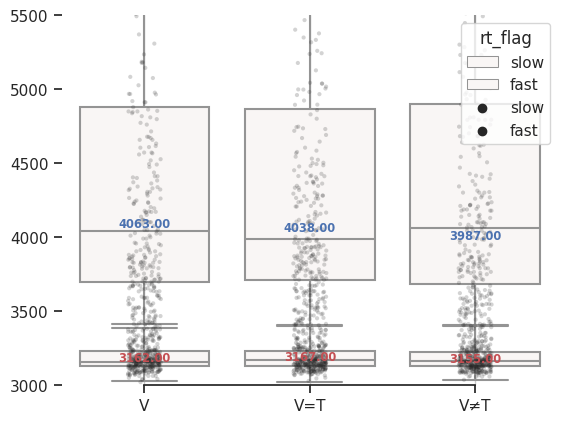

In [759]:
# Set the style of the graph
sns.set_theme(style='ticks')
 
# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots()

# Select data for 'slow' and 'fast' separately
df_slow = work_df_no_outl[work_df_no_outl['rt_flag'] == 'slow']
df_fast = work_df_no_outl[work_df_no_outl['rt_flag'] == 'fast']

# Calculate the natural logarithm of 'time_ms' with base 10 and create a new column 'rt_log'
#df_slow['rt_log'] = df_slow['time_ms'].apply(lambda x: math.log(x, 10))
#df_fast['rt_log'] = df_fast['time_ms'].apply(lambda x: math.log(x, 10))

# Plotting boxplot for 'slow'
box_plot_slow = sns.boxplot(
    data=df_slow, y='time_ms', x='feedbackType',
    palette="vlag", whis=[0, 100], showfliers=False,
    hue='rt_flag'
)

# Plotting boxplot for 'fast'
box_plot_fast = sns.boxplot(
    data=df_fast, y='time_ms', x='feedbackType',
    palette="vlag", whis=[0, 100], showfliers=False,
    hue='rt_flag'
)

# Calculate medians for 'slow' and 'fast' separately
medians_slow = df_slow.groupby(['feedbackType'])['time_ms'].median()
medians_fast = df_fast.groupby(['feedbackType'])['time_ms'].median()

# Add points to show each observation for both 'slow' and 'fast'
sns.stripplot(
    data=df_slow, y='time_ms', x='feedbackType', size=3, color=".3", alpha=0.2, dodge=True,
    hue='rt_flag'
)

sns.stripplot(
    data=df_fast, y='time_ms', x='feedbackType', size=3, color=".3", alpha=0.2, dodge=True,
    hue='rt_flag'
)

# Annotate median values for 'slow'
for xtick, median in zip(box_plot_slow.get_xticks(), medians_slow):
    ax.text(xtick, median, f'{median:.2f}', horizontalalignment='center', size='x-small', color='b', weight='semibold')

# Annotate median values for 'fast'
for xtick, median in zip(box_plot_fast.get_xticks(), medians_fast):
    ax.text(xtick, median, f'{median:.2f}', horizontalalignment='center', size='x-small', color='r', weight='semibold')


# Change x-axis labels
new_labels = ['V', 'V=T', 'V≠T']  # Corresponding to 'none', 'congruent', 'incongruent'
ax.set_xticklabels(new_labels)


# Show the plot
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="")
ax.set_ylim(3000,5500)
sns.despine(trim=True, left=True)

plt.show()


In [760]:
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import MultiComparison

# Select data for 'slow' and 'fast' separately
df_slow = work_df_no_outl[work_df_no_outl['rt_flag'] == 'slow']
df_fast = work_df_no_outl[work_df_no_outl['rt_flag'] == 'fast']

# Perform two-way ANOVA for 'slow' data
model_slow = ols('rt_log ~ feedbackType * ptcp', data=df_slow).fit()
anova_table_slow = sm.stats.anova_lm(model_slow, typ=2)

# Perform two-way ANOVA for 'fast' data
model_fast = ols('rt_log ~ feedbackType * ptcp', data=df_fast).fit()
anova_table_fast = sm.stats.anova_lm(model_fast, typ=2)

print("Two-Way ANOVA for 'slow' data:")
print(anova_table_slow)

print("\nTwo-Way ANOVA for 'fast' data:")
print(anova_table_fast)
# Create MultiComparison objects
mc_slow = MultiComparison(df_slow['rt_log'], df_slow['feedbackType'])
mc_fast = MultiComparison(df_fast['rt_log'], df_fast['feedbackType'])

# Run the Tukey post-hoc test for 'slow' data
result_slow = mc_slow.tukeyhsd()

# Run the Tukey post-hoc test for 'fast' data
result_fast = mc_fast.tukeyhsd()

# Print the results
print("Tukey Post-Hoc Test for 'slow' data:")
print(result_slow)

print("\nTukey Post-Hoc Test for 'fast' data:")
print(result_fast)

Two-Way ANOVA for 'slow' data:
                      sum_sq     df         F        PR(>F)
feedbackType        0.001761    2.0  0.042521  9.583727e-01
ptcp                2.218429   19.0  5.637669  2.180320e-13
feedbackType:ptcp   0.834390   38.0  1.060212  3.732392e-01
Residual           18.639527  900.0       NaN           NaN

Two-Way ANOVA for 'fast' data:
                     sum_sq      df         F        PR(>F)
feedbackType       0.000242     2.0  1.229311  2.929248e-01
ptcp               0.016910    19.0  9.030329  2.608230e-24
feedbackType:ptcp  0.003479    38.0  0.928930  5.944571e-01
Residual           0.101018  1025.0       NaN           NaN
Tukey Post-Hoc Test for 'slow' data:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
  congruent incongruent  -0.0003 0.9997 -0.0288 0.0283  False
  congruent        none  -0.0048 0.9125 -0.0327  0.0

In [761]:

# Select data for 'slow' and 'fast' separately
df_slow = work_df_no_outl
#df_fast = work_df_no_outl[work_df_no_outl['rt_flag'] == 'fast']

# Perform two-way ANOVA for 'slow' data
model_slow = ols('rt_log ~ feedbackType * ptcp', data=df_slow).fit()
anova_table_slow = sm.stats.anova_lm(model_slow, typ=2)

print("Two-Way ANOVA for All data Taken together:")
print(anova_table_slow)

Two-Way ANOVA for All data Taken together:
                      sum_sq      df          F        PR(>F)
feedbackType        0.020793     2.0   0.684681  5.043700e-01
ptcp                3.597391    19.0  12.469376  3.817891e-37
feedbackType:ptcp   0.746923    38.0   1.294502  1.084114e-01
Residual           30.140460  1985.0        NaN           NaN


They do not seem significantly different. 

### Step 4: Adjust Median per Participant using variance. 

## Analysis


### RACE MODEL INEQUALITY:
this code is stracted from the following paper.
Innes, B.R., Otto, T.U. A comparative analysis of response times shows that multisensory benefits and interactions are not equivalent. Sci Rep 9, 2921 (2019). https://doi.org/10.1038/s41598-019-39924-6

#### GENERAL PREFORMANCE

##### Mistakes

In [762]:

# Create an empty dictionary to store results
results = {}

# List of feedback types
feedback_types = ['none', 'congruent', 'incongruent']

for feedback_type in feedback_types:
    subsample = work_df_no_outl['feedbackType'] == feedback_type
    sample_mean = work_df_no_outl.loc[subsample, 'mistake_flag'].mean()
    sem = stats.sem(work_df_no_outl.loc[subsample, 'mistake_flag'])
    results[feedback_type] = {'Sample Mean': sample_mean, 'SEM': sem}

# Print the results
for feedback_type, result in results.items():
    print(f"Feedback Type: {feedback_type}")
    print(f"Sample Mean (Proportion of Mistakes): {result['Sample Mean']:.2%}")
    print(f"Standard Error of the Mean (SEM): {result['SEM']:.2%}")
    print()

import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(work_df_no_outl['feedbackType'], work_df_no_outl['mistake_flag'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")



Feedback Type: none
Sample Mean (Proportion of Mistakes): 7.50%
Standard Error of the Mean (SEM): 1.00%

Feedback Type: congruent
Sample Mean (Proportion of Mistakes): 7.39%
Standard Error of the Mean (SEM): 1.01%

Feedback Type: incongruent
Sample Mean (Proportion of Mistakes): 6.67%
Standard Error of the Mean (SEM): 0.96%

Chi-squared statistic: 0.41804244328454276
P-value: 0.8113780166866877


To asses the data quality, we first checked performance (misses). During the VR experiment the wrongly placed balls rate was 7.19% (± 0.57%, SEM). When running a chi-square test the proportions do not seemt to be significantly different. 

##### Repeated Measure ANOVA for conditions. 

To asses wether the experimental manipulations had an impact or not I will run repeated measures ANOVA comparing median values. A one way repated measure ANOVA for Feedback Type showed a sifnigicant main effect for our stimulus contstruction F(2,38) = 3.436, p<0.05, 

In [763]:
# Your code for ANOVA
data = work_df_no_outl
subject_id = 'ptcp'
dependent_variable = 'rt_log'
independent_variable = 'feedbackType'

rm = MyCustomAnovaRM(data, dependent_variable, subject=subject_id, within=[independent_variable], aggregate_func=np.median)
res = rm.fit()

# Access the MSE from the ANOVA results

print(res.anova_table)


Intercept
C(feedbackType, Sum)
C(ptcp, Sum)
                 T3 SS  T3 SS (error)  Num DF  Den DF   F Value    Pr > F  \
feedbackType  0.000441       0.004877     2.0    38.0  3.436096  0.042493   

                 eta^2  par.eta^2   omega^2  
feedbackType  0.004043   0.082925  0.001688  


In [764]:
import pingouin as pg 


data = work_df_no_outl
subject_id = 'ptcp'
dependent_variable = 'rt_log'
independent_variable = 'feedbackType'

# Aggregate the data by the median of 'rt_log'
aggregated_data = data.groupby([subject_id, independent_variable])['rt_log'].median().reset_index()

aov = pg.rm_anova(dv=dependent_variable, within=independent_variable,

                  subject=subject_id, data=aggregated_data, detailed=False, effsize="np2")

print(aov.round(3))
print()



# Create an empty dictionary to store results
aggregated_data = data.groupby([subject_id, independent_variable])['rt_log'].median().reset_index()

results = {}

# List of feedback types
feedback_types = ['none', 'congruent', 'incongruent']

for feedback_type in feedback_types:
    subsample = aggregated_data['feedbackType'] == feedback_type
    sample_median = aggregated_data.loc[subsample, 'rt_log'].median()  # Use median() instead of mean()
    sem = stats.sem(aggregated_data.loc[subsample, 'rt_log'])
    results[feedback_type] = {'Sample Median': sample_median, 'SEM': sem}

# Print the results
for feedback_type, result in results.items():
    print(f"Feedback Type: {feedback_type}")
    print(f"Sample Median: {result['Sample Median']:.4f}")
    print(f"Standard Error of the Mean (SEM): {result['SEM']:.4f}")
    print()

         Source  ddof1  ddof2      F  p-unc    np2    eps
0  feedbackType      2     38  3.436  0.042  0.153  0.936

Feedback Type: none
Sample Median: 3.5219
Standard Error of the Mean (SEM): 0.0106

Feedback Type: congruent
Sample Median: 3.5198
Standard Error of the Mean (SEM): 0.0088

Feedback Type: incongruent
Sample Median: 3.5254
Standard Error of the Mean (SEM): 0.0097



/home/perdices/.local/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


REPLACE WITH MY STUDIO HERE 
To assess whether the experimental manipulations mimicked the diversity of RSE studies, we next tested
median RTs (Table S1). A 2 × 2 × 3 repeated-measures ANOVA showed a significant main effect of stimulus
construction, F(1, 19) = 154.59, p < 0.001, ηp2 = 0.89. RTs were faster with simple (0.300 ± 0.010 s) than with
complex stimuli (0.416 ± 0.015 s). Hence, the experimental factor stimulus construction successfully manipulated
RTs.

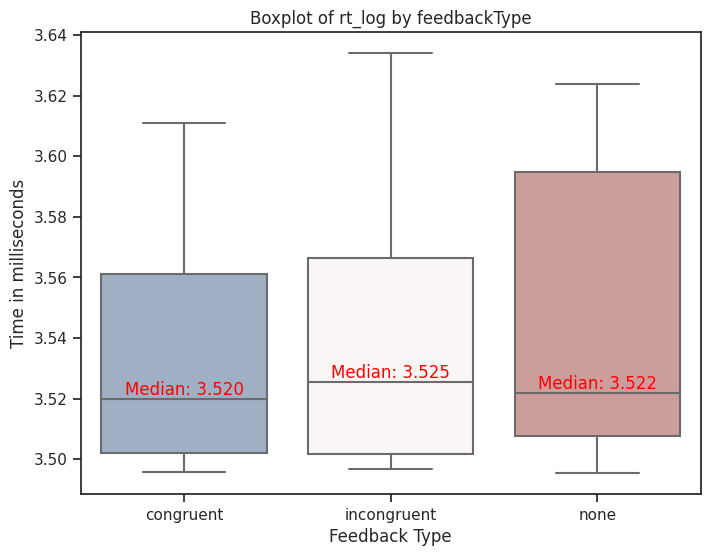

In [765]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'feedbackType' to a categorical variable
#data['feedbackType'] = work_df_no_outl['feedbackType'].astype('category')

# Calculate median values for each 'feedbackType' group
medians = aggregated_data.groupby('feedbackType')['rt_log'].median()

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=aggregated_data, x='feedbackType', y='rt_log',  showfliers=False, palette='vlag')
plt.title('Boxplot of rt_log by feedbackType')
plt.xlabel('Feedback Type')
plt.ylabel('Time in milliseconds')

# Display the median values on the plot
for i, median_value in enumerate(medians):
    text = f'Median: {median_value:.3f}'
    plt.text(i, median_value, text, ha='center', va='bottom', fontsize=12, color='red')

# Change x-axis labels
#new_labels = ['V=T', 'V≠T', 'V' ]  # Corresponding to 'none', 'congruent', 'incongruent'
#plt.xticks(range(len(new_labels)), new_labels)

plt.show()

In [766]:
posthoc = pg.pairwise_tukey(data=aggregated_data, dv='rt_log', between='feedbackType')
print(posthoc)

             A            B   mean(A)   mean(B)      diff        se         T  \
0    congruent  incongruent  3.536186  3.540669 -0.004483  0.013777 -0.325389   
1    congruent         none  3.536186  3.545574 -0.009388  0.013777 -0.681461   
2  incongruent         none  3.540669  3.545574 -0.004906  0.013777 -0.356072   

    p-tukey    hedges  
0  0.943366 -0.106138  
1  0.775200 -0.210586  
2  0.932584 -0.105653  


##### Examining additionally in Variability, as measure by median absulute deviation (MAD)

In [770]:


# Group the data by 'subject_id' and 'feedbackType' and calculate the MAD
grouped_data = data.groupby(['ptcp', 'feedbackType'])['rt_log'].apply(lambda x: np.median(np.abs(x - np.median(x)))).reset_index()

# Rename the 'rt_log' column to 'MAD'
grouped_data.rename(columns={'rt_log': 'MAD'}, inplace=True)


dependent_variable = 'MAD'
independent_variable = 'feedbackType'

aov = pg.rm_anova(dv=dependent_variable, within=independent_variable,

                  subject='ptcp', data=grouped_data, detailed=True, effsize="np2")

print(aov.round(3))
print()


         Source     SS  DF   MS      F  p-unc   np2    eps
0  feedbackType  0.000   2  0.0  0.386  0.683  0.02  0.786
1         Error  0.004  38  0.0    NaN    NaN   NaN    NaN



/home/perdices/.local/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


#### Multisensory Benefits

In [ ]:
#---CUMULATIVE DISTRIBUTION---------------------------------------------
# using correct counter 
# Referencing code from Rolf Ulrich and Chatgpt adaptation. 
import numpy as np
import matplotlib.pyplot as plt

def race_model(X, Y, Z, P, Plot):
    # X, Y, Z are arrays with RTs for conditions Cx, Cy, Cz, respectively.
    # P is an array which contains the probabilities for computing percentiles.
    # If Plot is True, a plot of the result is generated.
    
    # Check for ties and get maximum t value
    Ux, Rx, Cx = ties(X)
    Uy, Ry, Cy = ties(Y)
    Uz, Rz, Cz = ties(Z)
    tmax = int(np.ceil(max(max(X), max(Y), max(Z))))
    T = np.arange(1, tmax + 1)
    
    # Get function values of G
    Gx = CDF(Ux, Rx, Cx, tmax) 
    Gy = CDF(Uy, Ry, Cy, tmax)
    Gz = CDF(Uz, Rz, Cz, tmax)
    
    # Compute B = Gx plus Gy
    B = [Gx[t] + Gy[t] for t in range(tmax)]
    
    # Check whether requested percentiles can be computed
    OKx = check(Ux[0], P[0], Gx)
    if not OKx:
        print('Not enough X values to compute requested percentiles')
        return [None, None, None, None]
    
    OKy = check(Uy[0], P[0], Gy)
    if not OKy:
        print('Not enough Y values to compute requested percentiles')
        return [None, None, None, None]
    
    OKz = check(Uz[0], P[0], Gz)
    if not OKz:
        print('Not enough Z values to compute requested percentiles')
        return [None, None, None, None]
    
    # Determine percentiles
    Xp = get_percentile(P, Gx, tmax)
    Yp = get_percentile(P, Gy, tmax)
    Zp = get_percentile(P, Gz, tmax)
    Bp = get_percentile(P, B, tmax)
    generated_plot = []
    # Generate a plot if requested
    if Plot:
        plt.figure(figsize=(12,6))
        #bin_edges = range(3000, int(work_df_no_outl['time_ms'].max()) + 100, 100)
        plt.plot(Xp, P, '-o', label='G_x(t) - (Visual Only)')
        plt.plot(Yp, P, '-o', label='G_y(t) - (Visual + Tactile Incongruent )')
        plt.plot(Zp, P, '-o', label='G_z(t) - (Visual + Tactile Congruent)')
        
        #plt.plot(Bp, P, '-', label='G_x(t)+G_y(t)')
        #plt.axis([min(Ux + Uy + Uz) - 10, 
        #          tmax + 10, 
        #          -0.03, 1.03])
        # Define the time range and step for x-axis labels
        x_ticks = range(3000, 6500 + 10, 100)

# Set the x-tick positions and labels
        plt.xticks(x_ticks, [str(tick) + ' ms' for tick in x_ticks], rotation=90)
        plt.grid()
        plt.title('Test of the Rac e Model Inequality', fontsize=16)
        plt.xlabel('Time t (ms)', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.legend(loc=4)
        generated_plot = plt.gcf()
        plt.show()
    
    return Xp, Yp, Zp, Bp, generated_plot

def check(U1, P1, G):
    for t in range(U1 - 2, U1 + 3):
        if G[t] > P1 and G[t - 1] == 0:
            return False
    return True

def get_percentile(P, G, tmax):
    Tp = []
    for p in P:
        cc = 100
        c = 0
        for t in range(tmax):
            if abs(G[t] - p) < cc:
                c = t
                cc = abs(G[t] - p)
        
        if p > G[c]:
            Tp.append(c + (p - G[c]) / (G[c + 1] - G[c]))
        else:
            Tp.append(c + (p - G[c]) / (G[c] - G[c - 1]))
    return Tp

def ties(W):
    # Count the number k of unique values and store these values in U.
    W = sorted(W)
    n = len(W)
    k = 1
    U = [W[0]]
    
    for i in range(1, n):
        if W[i] != W[i - 1]:
            k += 1
            U.append(W[i])
    
    # Determine the number of replications R
    R = [0] * k
    
    for i in range(k):
        for j in range(n):
            if U[i] == W[j]:
                R[i] += 1
    
    # Determine the cumulative frequency
    C = [0] * k
    C[0] = R[0]
    
    for i in range(1, k):
        C[i] = C[i - 1] + R[i]
    
    return U, R, C

def CDF(U, R, C, maximum):
    G = [0] * maximum
    k = len(U)
    n = C[k - 1]
    
    for i in range(k):
        U[i] = round(U[i])
    
    for t in range(U[0]):
        G[t] = 0
    
    for t in range(U[0], U[1]):
        G[t] = (R[0] / 2 + (R[0] + R[1]) / 2 * (t - U[0]) / (U[1] - U[0])) / n
    
    for i in range(1, k - 1):
        for t in range(U[i], U[i + 1]):
            G[t] = (C[i - 1] + R[i] / 2 + (R[i] + R[i + 1]) / 2 * (t - U[i]) / (U[i + 1] - U[i])) / n
    
    for t in range(U[k - 1], maximum):
        G[t] = 1
    
    return G
# Creating function data from my data 
X = work_df_no_outl.loc[work_df_no_outl['feedbackType'] == 'none', 'time_ms']
Y = work_df_no_outl.loc[work_df_no_outl['feedbackType'] == 'incongruent', 'time_ms']
Z = work_df_no_outl.loc[work_df_no_outl['feedbackType'] == 'congruent', 'time_ms']
#
#X = work_df2.loc[work_df2['feedbackType'] == 'none', 'time_ms']
#Y = work_df2.loc[work_df2['feedbackType'] == 'incongruent', 'time_ms']
#Z = work_df2.loc[work_df2['feedbackType'] == 'congruent', 'time_ms']

# Example usage:
#X = [10, 15, 20, 25] 
#Y = [12, 16, 18, 24]
#Z = [9, 14, 21, 27]
P = [ 0.03,0.06, 0.09, 0.1,0.13,0.16,0.19, 0.2,0.23, 0.26, 0.29, 0.3,0.33,0.36,0.39,0.4,0.43,0.46,0.49,0.5,0.6,0.7,0.8,0.9,0.93]
Plot = False

Xp, Yp, Zp, Bp, generated_plot = race_model(X, Y, Z, P, Plot)

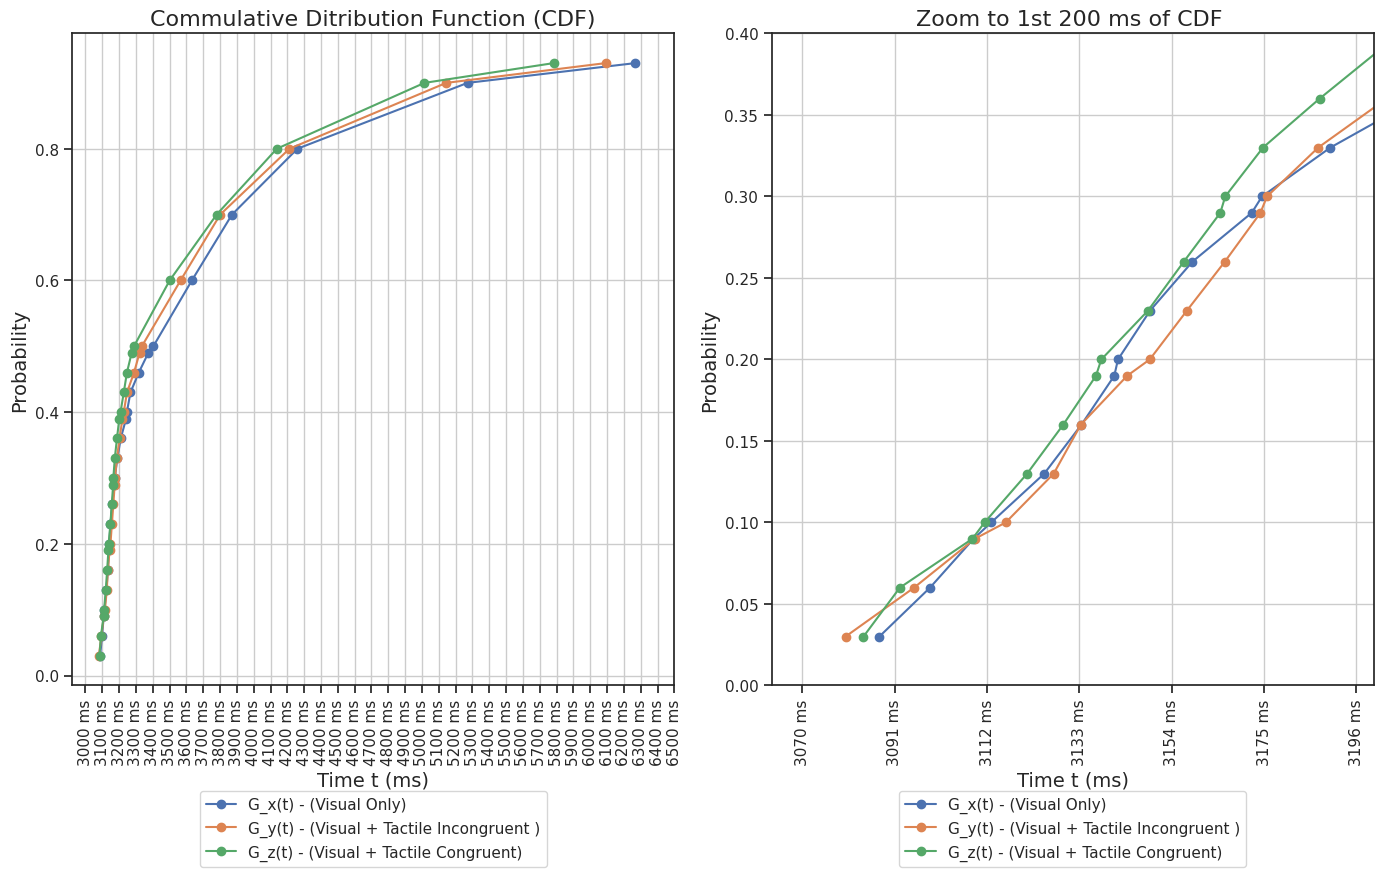

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 9))
# bin_edges = range(3000, int(work_df_no_outl['time_ms'].max()) + 100, 100)

# Plot on the first subplot (axes[0])
axes[0].plot(Xp, P, '-o', label='G_x(t) - (Visual Only)')
axes[0].plot(Yp, P, '-o', label='G_y(t) - (Visual + Tactile Incongruent )')
axes[0].plot(Zp, P, '-o', label='G_z(t) - (Visual + Tactile Congruent)')

x_ticks = range(3000, 6500 + 10, 100)

# Set the x-tick positions and labels
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels([str(tick) + ' ms' for tick in x_ticks], rotation=90)

#axes[0].set_ylim(0.0, 0.4)
#axes[0].set_xlim(3063, 3200)
axes[0].grid()
axes[0].set_title('Commulative Ditribution Function (CDF)', fontsize=16)
axes[0].set_xlabel('Time t (ms)', fontsize=14)
axes[0].set_ylabel('Probability', fontsize=14)
axes[0].legend(loc=4)


# Plot on the second subplot (axes[1])
axes[1].plot(Xp, P, '-o', label='G_x(t) - (Visual Only)')
axes[1].plot(Yp, P, '-o', label='G_y(t) - (Visual + Tactile Incongruent )')
axes[1].plot(Zp, P, '-o', label='G_z(t) - (Visual + Tactile Congruent)')

x_ticks = range(3070, 3200 + 10, 21)

# Set the x-tick positions and labels
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels([str(tick) + ' ms' for tick in x_ticks], rotation=90)

axes[1].set_ylim(0.0, 0.4)
axes[1].set_xlim(3063, 3200)
axes[1].grid()
axes[1].set_title('Zoom to 1st 200 ms of CDF ', fontsize=16)
axes[1].set_xlabel('Time t (ms)', fontsize=14)
axes[1].set_ylabel('Probability', fontsize=14)
axes[1].legend(loc=4)

# Move the legend outside and to the bottom of the graph
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))
# Move the legend outside and to the bottom of the graph
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))


plt.tight_layout()
plt.show()



I would define 2 groups that include the mayority of the trials. The first one ("Fast") goes from 3000 +100 -  3200 and the second one ("Fast") goes from from 3201 untill the outlier border. This, because the conditions concerning the Race Inequality model met are smore coherent within this groups. For the "Slow" asnwer over 3200 milliseconds the Visual Only Stimuli is slower thant the . Also each groups about 45% of all trials. 